In [171]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import numpy as  np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Load dataset with Pandas

In [172]:
diabetes = pd.read_csv('diabetes.csv')

# we want all column except the last columns for our feature
x_features = diabetes.iloc[:, 0:-1].values 

# Our targets is the last column, 'negative/position'
y_targets = diabetes.iloc[:, -1]

print(diabetes.groupby('Class').size())
print("dimension of diabetes data: {}".format(diabetes.shape))

Class
negative    500
positive    268
dtype: int64
dimension of diabetes data: (768, 8)


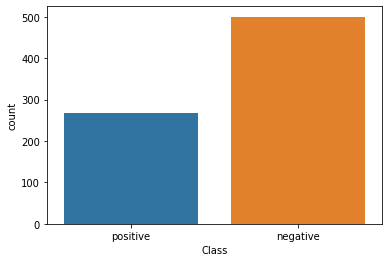

In [173]:
sns.countplot(diabetes['Class'],label="Count")

In [174]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Number of times pregnant      768 non-null    int64  
 1   Plasma glucose concentration  768 non-null    int64  
 2   Diastolic blood pressure      768 non-null    int64  
 3   Triceps skin fold thickness   768 non-null    int64  
 4   2-Hour serum insulin          768 non-null    int64  
 5   Body mass index               768 non-null    float64
 6   Age                           768 non-null    int64  
 7   Class                         768 non-null    object 
dtypes: float64(1), int64(6), object(1)
memory usage: 48.1+ KB


## Convert Target String to Numbers
Because our computer only recognize numbers 

In [175]:
y_targets = np.where(y_targets == 'negative', 0, 1)

# show the first 10 examples.
print (y_targets[:10])

[1 0 1 0 1 0 1 0 1 1]


## Normalization convert all input to range (-1, 1)

In [176]:
sc = StandardScaler()
x_features = sc.fit_transform(x_features)

## Custom DataLoader

In [177]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x 
        self.y = y
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

## Split data into train and validation set

In [178]:
# Convert data into tensor
x_features = torch.tensor(x_features)
y_targets = torch.tensor(y_targets)

dataset = CustomDataset(x_features, y_targets)

# 70 % for training and the rest for testing
train_dataset_length = int(len(dataset) * 0.7)

split_length = [train_dataset_length, len(dataset) - train_dataset_length]

train_dataset, val_dataset = torch.utils.data.random_split(dataset, split_length)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=32,
                                           shuffle=True)
 
# no need to shuffle val dataset
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                              batch_size=32)

In [179]:
class Model(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.hidden_0 = nn.Sequential(
            nn.Linear(in_features, 10),
            nn.Tanh()
        )
        self.hidden_1 = nn.Sequential(
            nn.Linear(10, 5),
            nn.Tanh()
        )
        self.out = nn.Sequential(
            nn.Linear(5, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.hidden_0(x)
        x = self.hidden_1(x)
        x = self.out(x)
        return x

In [180]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda')
model = Model(x_features.shape[1]).to(device)
learning_rate = 0.01
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate,
                             momentum=0.9)

In [181]:
epochs = 20
train_epoch_loss_history = []
val_epoch_loss_hisotry = []

train_epoch_accuracy = []
val_epoch_accuracy = []

for e in range(epochs):

    train_corrects = 0.0 
    train_batch_loss = 0.0
    train_epoch_loss = 0.0
    val_corrects = 0.0
    val_epoch_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Return 1 if output > 0.5 
        # Return 0 if output <= 0.5
        preds = (outputs>0.5).float()
        
        train_epoch_loss  += loss.item() 
        train_corrects += (preds == labels).sum().item()

    else:
        train_accuracy = 100. * train_corrects / len(train_loader.dataset)
        train_epoch_accuracy.append(train_accuracy)
        batch_idx = len(train_loader.dataset) / 32
        train_epoch_loss /= batch_idx
        train_epoch_loss_history.append(train_epoch_loss)

        print('epoch :', (e+1))
        print('Trian set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                train_corrects, len(train_loader.dataset),
                train_accuracy, train_epoch_loss))
    
        # torch.no_grad deactivate the auograd engine, 
        # reduce memory usage and speed up computations
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.float().to(device)
                val_labels = val_labels.float().to(device)
                val_outputs = model(val_inputs).squeeze(1)             
                val_loss = criterion(outputs, labels)

                val_preds = (val_outputs>0.5).float()
                val_epoch_loss += val_loss.item()
                val_corrects += (val_preds == val_labels).sum().item()
        
        val_accuracy = 100. * val_corrects / len(validation_loader.dataset)
        val_epoch_accuracy.append(val_accuracy)
        val_epoch_loss /= batch_idx
        val_epoch_loss_hisotry.append(val_epoch_loss)

        print('Valid set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                val_corrects, len(validation_loader.dataset),
                val_accuracy, val_epoch_loss))
        

epoch : 1
Trian set: Accuracy: 336.0/537 (63%), Average Loss: 0.680566
Valid set: Accuracy: 149.0/231 (65%), Average Loss: 0.305774
epoch : 2
Trian set: Accuracy: 348.0/537 (65%), Average Loss: 0.656224
Valid set: Accuracy: 152.0/231 (66%), Average Loss: 0.303921
epoch : 3
Trian set: Accuracy: 349.0/537 (65%), Average Loss: 0.634072
Valid set: Accuracy: 152.0/231 (66%), Average Loss: 0.308421
epoch : 4
Trian set: Accuracy: 349.0/537 (65%), Average Loss: 0.611354
Valid set: Accuracy: 155.0/231 (67%), Average Loss: 0.259142
epoch : 5
Trian set: Accuracy: 370.0/537 (69%), Average Loss: 0.584348
Valid set: Accuracy: 164.0/231 (71%), Average Loss: 0.270639
epoch : 6
Trian set: Accuracy: 398.0/537 (74%), Average Loss: 0.554894
Valid set: Accuracy: 172.0/231 (74%), Average Loss: 0.256667
epoch : 7
Trian set: Accuracy: 411.0/537 (77%), Average Loss: 0.527289
Valid set: Accuracy: 175.0/231 (76%), Average Loss: 0.225648
epoch : 8
Trian set: Accuracy: 411.0/537 (77%), Average Loss: 0.506695
Valid

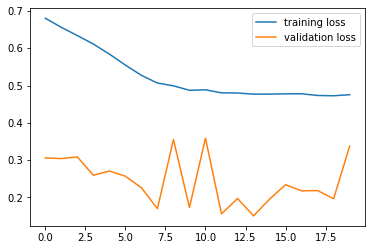

In [186]:
plt.plot(train_epoch_loss_history, label='training loss')
plt.plot(val_epoch_loss_hisotry, label='validation loss')
plt.legend()
plt.show()

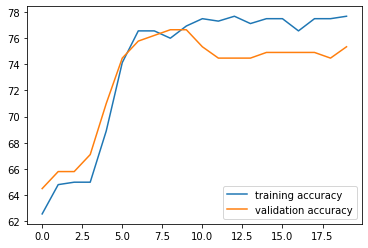

In [187]:
plt.plot(train_epoch_accuracy, label='training accuracy')
plt.plot(val_epoch_accuracy, label='validation accuracy')
plt.legend()
plt.savefig("accuracy comparision")
plt.show()
